# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101 dataset)
import zipfile

# Unzip the data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [2]:
# How many images in each folder?
import os

# Walkthrough 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

Use the `ImageDataGenerator` class to load in the images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE, 
                                                          batch_size=BATCH_SIZE, 
                                                          class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir, 
                                                        target_size=IMAGE_SHAPE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilist the model runs)

Callbacks are extra functionality we can add to the models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpointing witht the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tesnorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tesnorboard_callback

## Creating models using TensorFlow Hub

Previously we've used TensorFlow to create our own models layer by layer from scratch.

Now the majority of our model's layers are going to come from TensFlow Hub.

We can access pretrained models on : https://tfhub.dev/

Feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Compare the two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [21]:
# Make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str) : A TensFlow Hub feature extraction URL.
        num_classes (int) : Number of output neurons in the output layer,
        should be equal to number of target classes, default 10.
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False, # freeze the already learned patterns
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,)) 
    
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [22]:
# Create Resnet
resnet_model = create_model(resnet_url)

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [24]:
# Compile the resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [27]:
# Fit the resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20250201-184053
Epoch 1/5
24/24 [==============================] - 92s 4s/step - loss: 0.9387 - accuracy: 0.7147 - val_loss: 0.8470 - val_accuracy: 0.7344
Epoch 2/5
24/24 [==============================] - 90s 4s/step - loss: 0.6336 - accuracy: 0.8027 - val_loss: 0.7540 - val_accuracy: 0.7620
Epoch 3/5
24/24 [==============================] - 88s 4s/step - loss: 0.4786 - accuracy: 0.8707 - val_loss: 0.6986 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 91s 4s/step - loss: 0.3784 - accuracy: 0.9120 - val_loss: 0.6808 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 87s 4s/step - loss: 0.3092 - accuracy: 0.9307 - val_loss: 0.6471 - val_accuracy: 0.7900


The transfer learning feature extractor model out performed ALL of the previous models built before and with only 10% of the training data examples.

In [34]:
# Create a function to plot the loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    
    Args:
        history: TensorFlow model History object.
    
    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

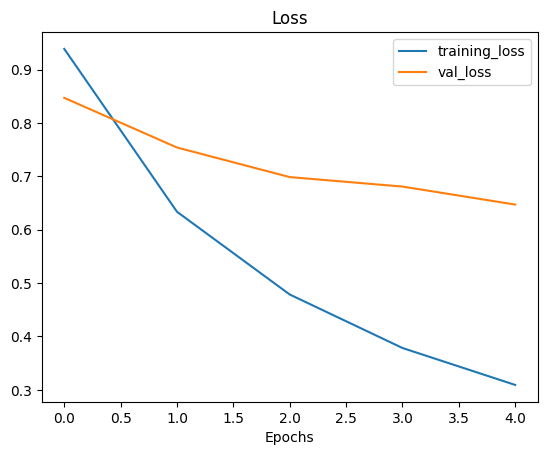

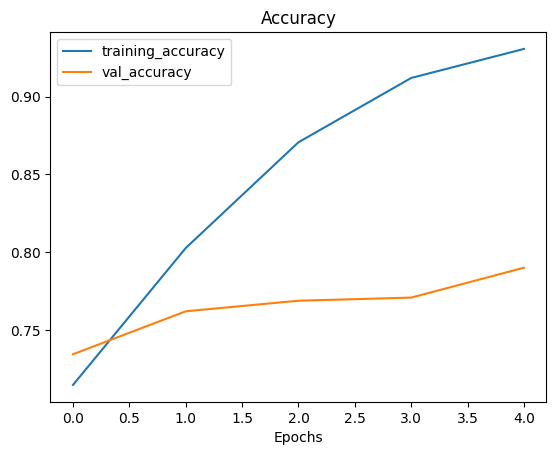

In [35]:
plot_loss_curves(history=resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [39]:
# Create efficientnetb0 feature extractor model
efficientnet_model = create_model(efficientnet_url)

In [41]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [42]:
# Compile the efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [44]:
# Fit efficientnet model to 10% of training data
EPOCHS = 5
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnet")]
                                                                                    )

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20250201-190216
Epoch 1/5
24/24 [==============================] - 83s 3s/step - loss: 1.8531 - accuracy: 0.4227 - val_loss: 1.3197 - val_accuracy: 0.7252
Epoch 2/5
24/24 [==============================] - 65s 3s/step - loss: 1.0725 - accuracy: 0.7760 - val_loss: 0.8773 - val_accuracy: 0.8136
Epoch 3/5
24/24 [==============================] - 62s 3s/step - loss: 0.7636 - accuracy: 0.8320 - val_loss: 0.7054 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 70s 3s/step - loss: 0.6129 - accuracy: 0.8693 - val_loss: 0.6168 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 61s 3s/step - loss: 0.5162 - accuracy: 0.8907 - val_loss: 0.5616 - val_accuracy: 0.8620


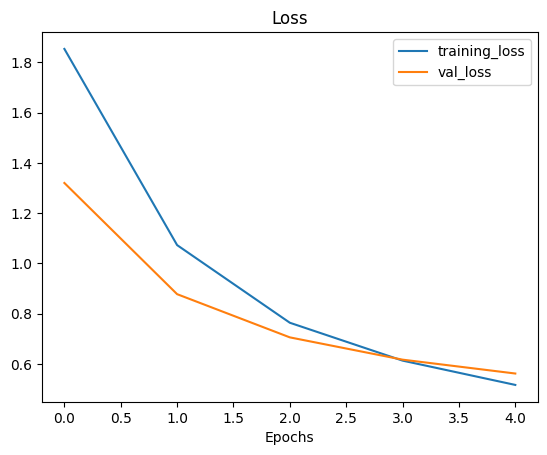

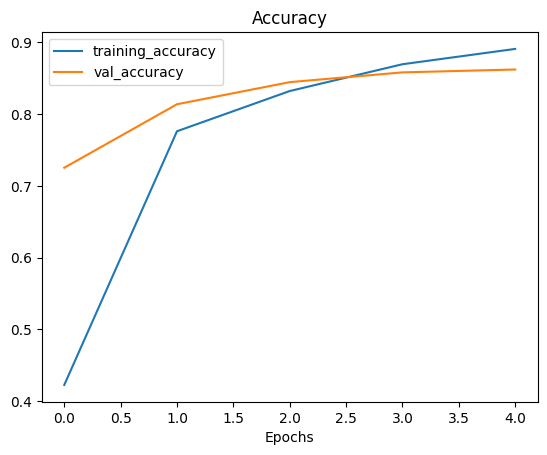

In [45]:
plot_loss_curves(efficientnet_history)

In [49]:
# How many layers efficientnet has?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for our own problem (.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing the models results using TensorBoard

In [50]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
    --one_shot    

^C
